# EDA

In [1]:
#supress update on pandas regarding TargetEncoding
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('winemag-data-130k-v2.csv')
display(data.head())

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [2]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


Text(0.5, 1.0, 'Target Histogram')

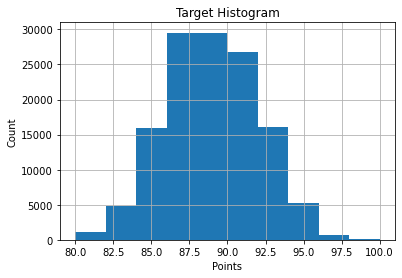

In [3]:
ax = data.points.hist()
ax.set_xlabel('Points')
ax.set_ylabel('Count')
ax.set_title('Target Histogram')

Target variable has a normal distribution

<AxesSubplot:xlabel='price', ylabel='points'>

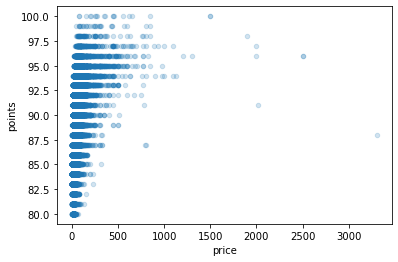

In [4]:
data[['points', 'price']].plot(kind='scatter', x='price', y='points', alpha=0.2)

Now creating a base model with only numerical features, so price vs points.  
Plot above is showing a possible linear correlation, so the model might not be bad.

# Base Linear Model

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

#dropping rows with missing price, since it's the only feature there is nothing else to use for predictions
base_data = data[['price', 'points']].copy()
base_data.dropna(inplace=True)

X = base_data['price']
y = base_data['points']
X = np.expand_dims(X, axis=1)

#No need for train test split because CV will perform that
#Linear Regression, Lasso and Ridge will perform identically since there is only 1 feature
#Therefore no regulazation is possible
lr_score = cross_val_score(LinearRegression(), X, y).mean()
tree_score = cross_val_score(DecisionTreeRegressor(), X, y).mean()
print(f'Linear Regression CV Score: {lr_score:.3f}')
print(f'Decision Tree CV Score: {tree_score:.3f}')

Linear Regression CV Score: 0.171
Decision Tree CV Score: 0.375


Base score with decision tree is much higher, now will introduce text features

In [6]:
data.taster_name.unique()

array(['Kerin O’Keefe', 'Roger Voss', 'Paul Gregutt',
       'Alexander Peartree', 'Michael Schachner', 'Anna Lee C. Iijima',
       'Virginie Boone', 'Matt Kettmann', nan, 'Sean P. Sullivan',
       'Jim Gordon', 'Joe Czerwinski', 'Anne Krebiehl\xa0MW',
       'Lauren Buzzeo', 'Mike DeSimone', 'Jeff Jenssen',
       'Susan Kostrzewa', 'Carrie Dykes', 'Fiona Adams',
       'Christina Pickard'], dtype=object)

In [7]:
display(data.taster_twitter_handle.unique())
data.drop(columns=['taster_twitter_handle'], inplace=True)

array(['@kerinokeefe', '@vossroger', '@paulgwine\xa0', nan, '@wineschach',
       '@vboone', '@mattkettmann', '@wawinereport', '@gordone_cellars',
       '@JoeCz', '@AnneInVino', '@laurbuzz', '@worldwineguys',
       '@suskostrzewa', '@bkfiona', '@winewchristina'], dtype=object)

twitter handle and user name are synonimous, won't use twitter since it's identical information and has less records

In [8]:
data[data.duplicated(keep=False)].sort_values('description').head(6)

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery
67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie


There are also some duplicated rows that will need to be dropped

In [9]:
data.nunique()

country            43
description    119955
designation     37979
points             21
price             390
province          425
region_1         1229
region_2           17
taster_name        19
title          118840
variety           707
winery          16757
dtype: int64

Columns with over 20 unique values should be target encoded, OHE will expand the training set and increase computational time.

Linear Regression with Vectorizer Score: 0.709
Linear Regression with TFID Vectorizer Score: 0.719


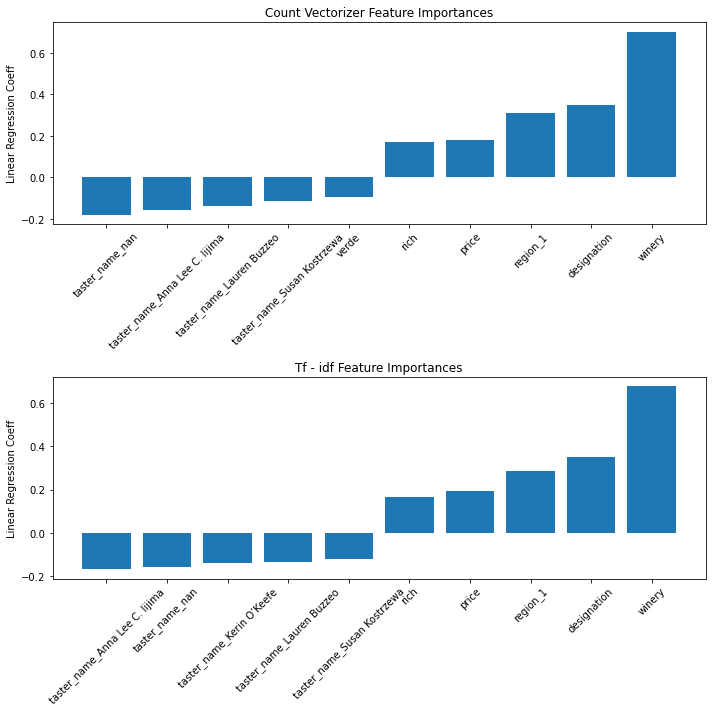

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

data.drop_duplicates(inplace=True)

target_cols = ['country', 'designation', 'province', 'region_1', 'region_2', 'title', 'winery', 'variety']
ohe_cols = ['taster_name']
cont_cols = ['price']
txt_cols = 'description'
X = data[target_cols + ohe_cols + cont_cols + [txt_cols]]
y = data.points
X_train, X_test, y_train, y_test = train_test_split(X, y)

#will fill in missing categorical values with NA.  
#Don't want to use the most common, rather keep those records separate.
#Since we aren't using any additional information from data this will not cause a data leak
fill_na_values = {col : 'NA' for col in target_cols + ohe_cols + [txt_cols]}

ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
                        ('cont', SimpleImputer(), cont_cols),
                        ('txt', CountVectorizer(stop_words='english', min_df=2), txt_col)])

lr_vectorizer = Pipeline([('ct', ct), ('scaler', StandardScaler(with_mean=False)), ('model', LinearRegression())])
vect_score = cross_val_score(lr_vectorizer, X_train, y_train, n_jobs=-1).mean()
#now will try to encode txt column with TFID Vectorizer
#Both work similarly, but TFID normalizes each word by frequency of appearance in document
ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
                        ('cont', SimpleImputer(), cont_cols),
                        ('txt', TfidfVectorizer(stop_words='english', min_df=2), txt_col)])


lr_tfid = Pipeline([('ct', ct), ('scaler', StandardScaler(with_mean=False)), ('model', LinearRegression())])
tfid_score = cross_val_score(lr_tfid, X_train, y_train, n_jobs=-1).mean()

print(f'Linear Regression with Vectorizer Score: {vect_score:.3f}')
print(f'Linear Regression with TFID Vectorizer Score: {tfid_score:.3f}')

#function to extract feature names
def get_feature_names(model, include_txt = True):
    features = []
    features += target_cols
    features += model.named_steps['ct'].named_transformers_['ohe'].get_feature_names_out().tolist()
    features += cont_cols
    if include_txt:
        features += model.named_steps['ct'].named_transformers_['txt'].get_feature_names_out().tolist()
    return np.array(features)

def plot_feature_importances(model, ax, plot_title = 'Most Important Features', top_n_features=5):
    coefs = model.named_steps['model'].coef_
    coef_order = np.argsort(coefs)
    coef_order = np.append(coef_order[:top_n_features], coef_order[-top_n_features:])
    features = get_feature_names(model)[coef_order]
    coefs = coefs[coef_order]
    ax.bar(features, coefs)
    ax.set_title(f'{plot_title}')
    ax.set_ylabel('Linear Regression Coeff')
    ax.tick_params(rotation = 45, axis='x')
    
#now inspecting feature importances
lr_vectorizer.fit(X_train, y_train)
lr_tfid.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10, 10))

plot_feature_importances(lr_vectorizer, ax1, 'Count Vectorizer Feature Importances')
plot_feature_importances(lr_tfid, ax2, 'Tf - idf Feature Importances')

fig.tight_layout()

LSA Score: 0.645


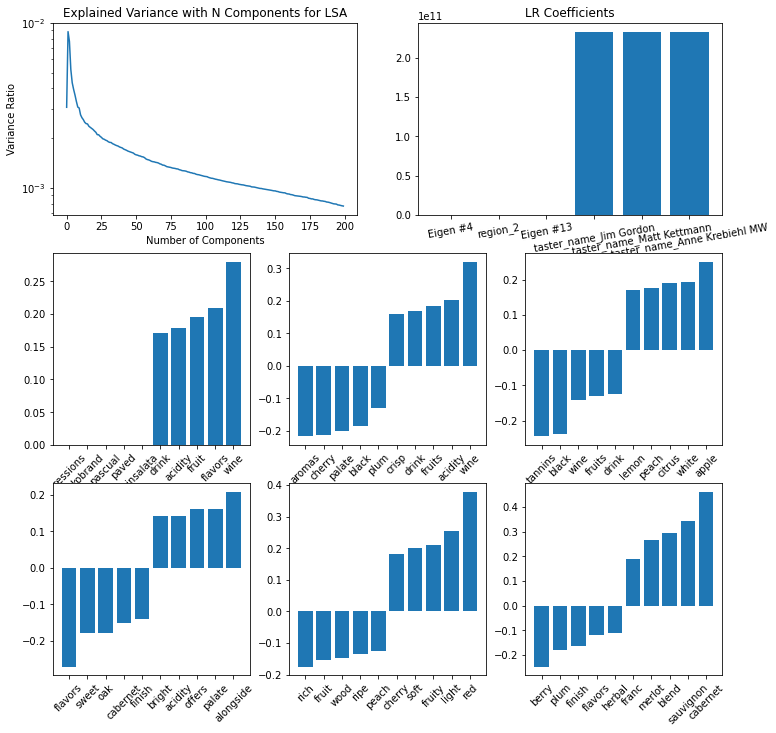

In [36]:
#now will build LSA with TruncatedSVD model for topic model representation
from sklearn.decomposition import TruncatedSVD

#how many components to create
n_components = 200

lsa_pipe = Pipeline([('tfid', TfidfVectorizer(stop_words='english', min_df=2)),
                     ('lsa', TruncatedSVD(n_components=n_components))])

ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
                        ('cont', SimpleImputer(), cont_cols),
                        ('txt', lsa_pipe, txt_col)])

lr_lsa = Pipeline([('ct', ct), ('scaler', MaxAbsScaler()), ('model', LinearRegression())])
lsa_score = cross_val_score(lr_lsa, X_train, y_train, n_jobs=-1).mean()
lr_lsa.fit(X_train, y_train)

print(f'LSA Score: {lsa_score:.3f}')

#plotting variance explained and feature importances
txt_ct = lr_lsa[0].named_transformers_['txt']
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(321)

#plotting explained variance
ax1.semilogy(txt_ct[1].explained_variance_ratio_)
ax1.set_title('Explained Variance with N Components for LSA')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Variance Ratio')

#plotting coefficients
ax3 = fig.add_subplot(322)
features = get_feature_names(lr_lsa, False)
features = np.append(features, [f'Eigen #{i}' for i in range(n_components)])
#need to find eigen vectors with the highest coefficient to plot later
coefs = lr_lsa[2].coef_
eigen_coefs = coefs[-n_components:]
#now picking top 6 coefficients
coef_order = np.argsort(coefs)
coef_order = np.append(coef_order[:3], coef_order[-3:])
coefs = coefs[coef_order]
features = features[coef_order]
ax3.bar(features, coefs)
ax3.set_title('LR Coefficients')
ax3.tick_params(rotation=10, axis='x')

#plotting top 6 Eigenvectors
num_of_eigens = 6
feature_names = txt_ct[0].get_feature_names_out()
for i in range(num_of_eigens):
    ax2 = fig.add_subplot(3,3, 4 + i)
    eigens = txt_ct[1].components_[i,:]
    eigens_order = np.argsort(eigens)
    eigens_order = np.append(eigens_order[:5], eigens_order[-5:])
    features = feature_names[eigens_order]
    eigens = eigens[eigens_order]
    ax2.bar(features, eigens)
    ax2.tick_params(rotation=45, axis='x')

Each eigen vector groups words from dictionary together, therefore associating words together by "Topic"  
Variance captured declines logorithmically after 100 n_components, will run with 100 components to compare the scores 

In [37]:
lr_lsa.set_params(ct__txt__lsa__n_components = 100)
lr_lsa_score = cross_val_score(lr_lsa, X_train, y_train).mean()
print(f'Score with 100 components: {lr_lsa_score:.3f}')

Score with 20 components: 0.629


Minor decrease in R2 score 0.02 with decrease a 400 components.

In [42]:
#now running NMF on the same data
from sklearn.decomposition import NMF

n_components = 100

lsa_pipe = Pipeline([('tfid', TfidfVectorizer(stop_words='english', min_df=2)),
                     ('lsa', NMF(n_components=n_components))])

ct = ColumnTransformer([('target', TargetEncoder(), target_cols),
                        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
                        ('cont', SimpleImputer(), cont_cols),
                        ('txt', lsa_pipe, txt_col)])

lr_lsa = Pipeline([('ct', ct), ('scaler', MaxAbsScaler()), ('model', LinearRegression())])
lsa_score = cross_val_score(lr_lsa, X_train, y_train, n_jobs=-1).mean()
print(f'NMF Score: {lsa_score:.3f}')

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: Th

NMF Score: 0.570
